Instalando dependências

In [1]:
!pip install crc

## **Parte 2 - Implementação do Algoritmo**

In [3]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i+r+1]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### **Teste do Algoritmo**

In [4]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010


### **Parte 3 - Script de Teste**

In [5]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

# --- Insira sua função calcular_crc_manual e xor_bits aqui ---

 # Usando um padrão de 16 bits como referência
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000 , 6000 , 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gere uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.30461944600006063, 'mem_pico_manual': 105.7509765625, 'tempo_lib': 0.08344451100015249, 'mem_pico_lib': 1.4453125}, {'tamanho': 3000, 'tempo_manual': 0.5680778700000246, 'mem_pico_manual': 211.2431640625, 'tempo_lib': 0.17057794199990894, 'mem_pico_lib': 1.21875}, {'tamanho': 6000, 'tempo_manual': 1.1540037130000655, 'mem_pico_manual': 422.1572265625, 'tempo_lib': 0.3589465679999648, 'mem_pico_lib': 1.21875}, {'tamanho': 16000, 'tempo_manual': 3.222668133999832, 'mem_pico_manual': 1125.2822265625, 'tempo_lib': 1.620014041999866, 'mem_pico_lib': 1.21875}]


## Gráficos

Geração de gráficos

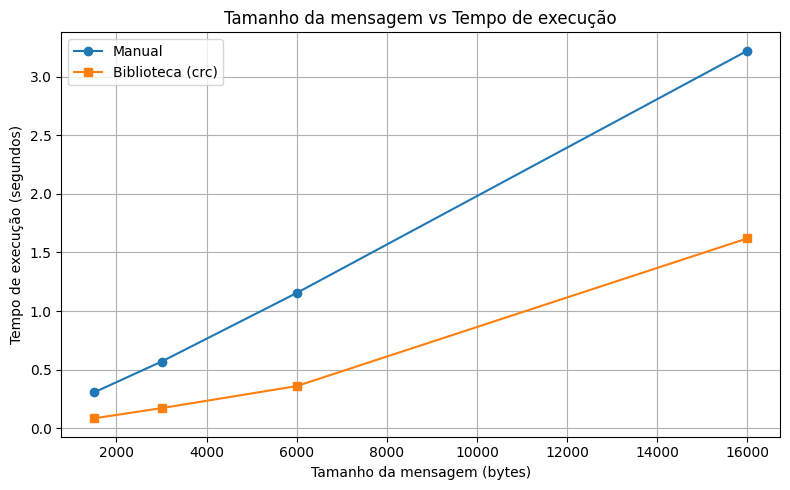

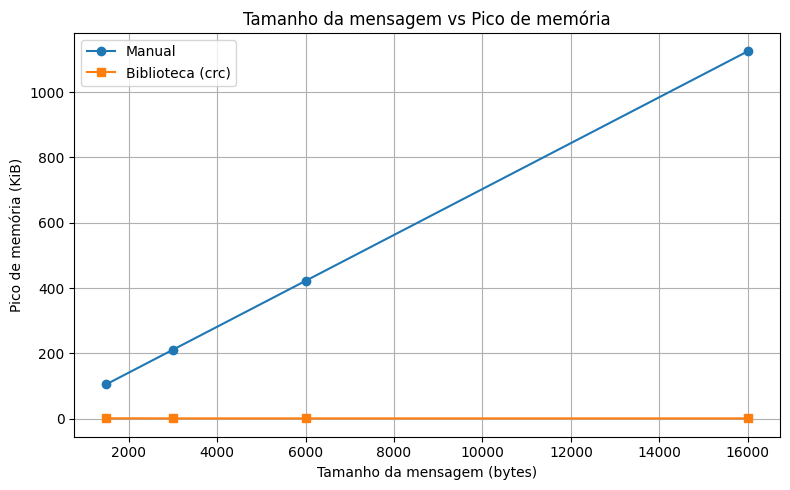

In [6]:
import matplotlib.pyplot as plt

# Dados
tamanhos = [r["tamanho"] for r in resultados]

tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]

mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]
# Gráfico 1: Tempo de execução
plt.figure(figsize=(8, 5))
plt.plot(tamanhos, tempos_manual, marker="o", label="Manual")
plt.plot(tamanhos, tempos_lib, marker="s", label="Biblioteca (crc)")

plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Tempo de execução (segundos)")
plt.title("Tamanho da mensagem vs Tempo de execução")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Gráfico 2: Pico de memória
plt.figure(figsize=(8, 5))
plt.plot(tamanhos, mem_manual, marker="o", label="Manual")
plt.plot(tamanhos, mem_lib, marker="s", label="Biblioteca (crc)")

plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Pico de memória (KiB)")
plt.title("Tamanho da mensagem vs Pico de memória")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dados da maquina para o relatório

In [7]:
import platform
import os

print("Processador:", platform.processor())
print("Arquitetura:", platform.machine())
print("Sistema:", platform.system(), platform.release())
print("Núcleos lógicos:", os.cpu_count())


Processador: x86_64
Arquitetura: x86_64
Sistema: Linux 6.6.105+
Núcleos lógicos: 2


parte 4: Diego - Matrícula de fim 0 ou seja  CRC-16/MODBUS

In [8]:
def xor_bits(a: str, b: str) -> str:
    return "".join("0" if bit_a == bit_b else "1" for bit_a, bit_b in zip(a, b))

def calcular_crc_manual(mensagem_bits: str, polinomio_bits: str) -> str:
    grau = len(polinomio_bits) - 1
    resto = list(mensagem_bits + "0" * grau)

    for i in range(len(mensagem_bits)):
        if resto[i] == "1":
            for j in range(len(polinomio_bits)):
                resto[i + j] = "0" if resto[i + j] == polinomio_bits[j] else "1"

    crc_bits = "".join(resto[-grau:])
    return crc_bits

polinomio = "11000000000000101"
CRC = calcular_crc_manual(mensagem_bits, polinomio)
print("CRC (bits):", CRC)
print("Tamanho CRC:", len(CRC))


CRC (bits): 1001111100111000
Tamanho CRC: 16


VARIAVEL	VALOR

MENSAGEM:	Diego de Lima Cruz

MENSAGEM_BASE:	010001000110100101100101011001110110111100100000011001000110010100100000010011000110100101101101011000010010000001000011011100100111010101111010

CRC:	1001001110010010

Procedimento de teste


In [9]:
import random
from crc import Calculator, Crc16


nome = "Diego de Lima Cruz"
mensagem_bytes = nome.encode("ascii")
mensagem_bits = "".join(format(b, "08b") for b in mensagem_bytes)

polinomio = "11000000000000101"  # CRC-16/MODBUS, 17 bits
grau_crc = len(polinomio) - 1    # 16

# CRC pela sua implementação manual
crc_manual = calcular_crc_manual(mensagem_bits, polinomio)

print("MENSAGEM       :", nome)
print("MENSAGEM_BASE  :", mensagem_bits)
print("CRC (manual)   :", crc_manual)

# Biblioteca (CRC-16/MODBUS)
calculator_lib = Calculator(Crc16.MODBUS)
crc_lib = calculator_lib.checksum(mensagem_bytes)

print("CRC (biblioteca, inteiro):", crc_lib)

# Vamos montar o QUADRO_TRANSMITIDO PARA CADA IMPLEMENTAÇÃO:
# Manual: bits
quadro_tx_bits_manual = mensagem_bits + crc_manual

# Biblioteca: bytes (CRC em 2 bytes - MODBUS normalmente usa little-endian)
crc_lib_bytes = crc_lib.to_bytes(2, byteorder="little")
quadro_tx_bytes_lib = mensagem_bytes + crc_lib_bytes

# Funções auxiliares

def bits_para_bytes(bits: str) -> bytes:
    """Converte string de bits (múltiplo de 8) para bytes."""
    return bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))

def bytes_para_bits(b: bytes) -> str:
    return "".join(format(x, "08b") for x in b)

def injeta_erro_rajada(bits: str, n: int):
    """Inverte n bits consecutivos a partir de uma posição aleatória."""
    if n > len(bits):
        raise ValueError("Rajada maior que o quadro!")
    inicio = random.randint(0, len(bits) - n)
    bits_lista = list(bits)
    for i in range(inicio, inicio + n):
        bits_lista[i] = "1" if bits_lista[i] == "0" else "0"
    bits_corrompidos = "".join(bits_lista)
    return bits_corrompidos, inicio

# --- Parâmetros do teste ---
NUM_TESTES = 10
N_BITS_RAJADA = 20  # você pode mudar, ex: 17, 20, 32, etc.

resultados_testes = []

for teste in range(1, NUM_TESTES + 1):
    print(f"\n=== Teste {teste} ===")

    # 1) Quadro transmitido da implementação manual (bits)
    quadro_tx_bits = quadro_tx_bits_manual

    # 2) Injeta mesma rajada (posição e tamanho) na versão em bits (manual)
    quadro_corrompido_bits, pos_erro = injeta_erro_rajada(quadro_tx_bits, N_BITS_RAJADA)

    # Padrão de erro = XOR(quadro_tx_bits, quadro_corrompido_bits)
    padrao_erro_bits = xor_bits(quadro_tx_bits, quadro_corrompido_bits)

    # 3) CRC do quadro corrompido - implementação manual
    crc_corrompido_manual = calcular_crc_manual(quadro_corrompido_bits, polinomio)
    erro_detectado_manual = (crc_corrompido_manual != "0" * grau_crc)

    # 4) Para a biblioteca, vamos aplicar A MESMA rajada de erro,
    #    mas no quadro em bytes (convertendo e usando os mesmos índices de bits).

    quadro_tx_bits_lib = bytes_para_bits(quadro_tx_bytes_lib)

    # Garante mesmo tamanho que a rajada (deve ser igual ou maior que manual)
    # (frames têm mesmo tamanho em bits: mensagem + 16 bits de CRC)
    assert len(quadro_tx_bits_lib) == len(quadro_tx_bits_manual)

    # Aplica o mesmo erro (mesma posição e tamanho)
    bits_lista_lib = list(quadro_tx_bits_lib)
    for i in range(pos_erro, pos_erro + N_BITS_RAJADA):
        bits_lista_lib[i] = "1" if bits_lista_lib[i] == "0" else "0"
    quadro_corrompido_bits_lib = "".join(bits_lista_lib)

    # Converte para bytes para a biblioteca calcular o checksum
    quadro_corrompido_bytes_lib = bits_para_bytes(quadro_corrompido_bits_lib)

    crc_corrompido_lib = calculator_lib.checksum(quadro_corrompido_bytes_lib)
    erro_detectado_lib = (crc_corrompido_lib != 0)

    print(f"Posição inicial da rajada   : {pos_erro}")
    print(f"Comprimento da rajada (n)   : {N_BITS_RAJADA}")
    print(f"CRC quadro corrompido (man.): {crc_corrompido_manual}")
    print(f"CRC quadro corrompido (lib.): {crc_corrompido_lib}")
    print(f"Erro detectado (manual)?    : {erro_detectado_manual}")
    print(f"Erro detectado (biblioteca)?: {erro_detectado_lib}")

    resultados_testes.append({
        "teste": teste,
        "pos_erro": pos_erro,
        "n_bits_rajada": N_BITS_RAJADA,
        "padrao_erro_bits": padrao_erro_bits,
        "crc_corrompido_manual": crc_corrompido_manual,
        "crc_corrompido_lib": crc_corrompido_lib,
        "erro_detectado_manual": erro_detectado_manual,
        "erro_detectado_lib": erro_detectado_lib,
    })

print("\n--- RESUMO DOS 10 TESTES ---")
for r in resultados_testes:
    print(
        f"Teste {r['teste']}: pos={r['pos_erro']}, n={r['n_bits_rajada']}, "
        f"det_manual={r['erro_detectado_manual']}, det_lib={r['erro_detectado_lib']}"
    )


MENSAGEM       : Diego de Lima Cruz
MENSAGEM_BASE  : 010001000110100101100101011001110110111100100000011001000110010100100000010011000110100101101101011000010010000001000011011100100111010101111010
CRC (manual)   : 1001001110010010
CRC (biblioteca, inteiro): 58909

=== Teste 1 ===
Posição inicial da rajada   : 41
Comprimento da rajada (n)   : 20
CRC quadro corrompido (man.): 1101010100000100
CRC quadro corrompido (lib.): 26271
Erro detectado (manual)?    : True
Erro detectado (biblioteca)?: True

=== Teste 2 ===
Posição inicial da rajada   : 7
Comprimento da rajada (n)   : 20
CRC quadro corrompido (man.): 1001000111010011
CRC quadro corrompido (lib.): 848
Erro detectado (manual)?    : True
Erro detectado (biblioteca)?: True

=== Teste 3 ===
Posição inicial da rajada   : 96
Comprimento da rajada (n)   : 20
CRC quadro corrompido (man.): 0000001000101111
CRC quadro corrompido (lib.): 64340
Erro detectado (manual)?    : True
Erro detectado (biblioteca)?: True

=== Teste 4 ===
Posição inici

Encontrando ponto cego

In [10]:
def injeta_ponto_cego(quadro_bits: str, polinomio_bits: str):
    n = len(polinomio_bits)
    # escolhe posição aleatória onde o polinômio "cabe"
    inicio = random.randint(0, len(quadro_bits) - n)
    erro = ["0"] * len(quadro_bits)
    for i, bit in enumerate(polinomio_bits):
        if bit == "1":
            erro[inicio + i] = "1"
    padrao_erro = "".join(erro)
    quadro_corrompido = xor_bits(quadro_bits, padrao_erro)
    return quadro_corrompido, padrao_erro, inicio

print("\n=== TESTE ESPECIAL: PONTO CEGO ===")

quadro_bits = quadro_tx_bits_manual
quadro_corrompido_bits, padrao_erro_cego, pos_cego = injeta_ponto_cego(quadro_bits, polinomio)

crc_corrompido_manual_cego = calcular_crc_manual(quadro_corrompido_bits, polinomio)
detectado_manual_cego = (crc_corrompido_manual_cego != "0" * grau_crc)

# Para biblioteca, reaplicamos mesmo erro na versão em bits do quadro em bytes:
quadro_bits_lib = bytes_para_bits(quadro_tx_bytes_lib)
erro_lista = list(quadro_bits_lib)
for i, bit in enumerate(padrao_erro_cego):
    if bit == "1":
        erro_lista[i] = "1" if erro_lista[i] == "0" else "0"
quadro_corrompido_bits_lib_cego = "".join(erro_lista)
quadro_corrompido_bytes_lib_cego = bits_para_bytes(quadro_corrompido_bits_lib_cego)

crc_corrompido_lib_cego = calculator_lib.checksum(quadro_corrompido_bytes_lib_cego)
detectado_lib_cego = (crc_corrompido_lib_cego != 0)

print(f"Posição do ponto cego    : {pos_cego}")
print(f"Padrão de erro (ponto cego): {padrao_erro_cego}")
print(f"CRC corrompido (manual)  : {crc_corrompido_manual_cego}")
print(f"CRC corrompido (lib)     : {crc_corrompido_lib_cego}")
print(f"Erro detectado manual?   : {detectado_manual_cego}")
print(f"Erro detectado biblioteca?: {detectado_lib_cego}")



=== TESTE ESPECIAL: PONTO CEGO ===
Posição do ponto cego    : 4
Padrão de erro (ponto cego): 0000110000000000001010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
CRC corrompido (manual)  : 0000000000000000
CRC corrompido (lib)     : 26009
Erro detectado manual?   : False
Erro detectado biblioteca?: True


Função de suporte

In [11]:
import random
import os

from crc import Calculator, Crc16, Configuration

# Função de Cálculo Manual do CRC
def xor_bits(a, b):
    return "".join('0' if x == y else '1' for x, y in zip(a, b))

def calcular_crc_manual(dados_bits, gerador_bits):
    grau = len(gerador_bits) - 1
    mensagem_aumentada = list(dados_bits + '0' * grau)
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            for j in range(len(gerador_bits)):
                mensagem_aumentada[i + j] = '0' if mensagem_aumentada[i + j] == gerador_bits[j] else '1'
    return "".join(mensagem_aumentada[-grau:])

#Função de Injeção de Erro
def injeta_erro_aleatorio(quadro_bits, n_bits=20):
    """Inverte n bits aleatórios para simular ruído."""
    if n_bits >= len(quadro_bits): n_bits = len(quadro_bits) // 2
    pos = random.randint(0, len(quadro_bits) - n_bits)
    lista = list(quadro_bits)
    padrao = ['0'] * len(quadro_bits)

    for i in range(n_bits):
        lista[pos+i] = '1' if lista[pos+i] == '0' else '0'
        padrao[pos+i] = '1'

    return "".join(lista), "".join(padrao), pos

def injeta_ponto_cego(quadro_bits, poly_bits):
    """
    Injeta o próprio polinômio como erro.
    Matematicamente, somar o divisor ao dividendo não altera o resto (que é o CRC).
    Isso cria um erro invisível.
    """
    pos = random.randint(0, len(quadro_bits) - len(poly_bits))
    lista = list(quadro_bits)
    padrao = ['0'] * len(quadro_bits)

    #Aplica XOR com o polinômio na posição escolhida
    for i, bit_poly in enumerate(poly_bits):
        if bit_poly == '1':
            padrao[pos+i] = '1'
            lista[pos+i] = '1' if lista[pos+i] == '0' else '0'

    return "".join(lista), "".join(padrao), pos

In [12]:
#DADOS: Raphael Cavalcante Ramos (Final 7 - CRC-16/MAXIM)
nome_r = "Raphael Cavalcante Ramos"
#Binário fornecido
msg_bits_r = "010100100110000101110000011010000110000101100101011011000010000001000011011000010111011001100001011011000110001101100001011011100111010001100101001000000101001001100001011011010110111101110011"
# Polinômio MAXIM
poly_r = "10011000000010001"

#Calcula CRC Original
crc_r = calcular_crc_manual(msg_bits_r, poly_r)

print(f"=== ANÁLISE: {nome_r} ===")
print(f"| VARIAVEL        | VALOR |")
print(f"| :-              | :-    |")
print(f"| `MENSAGEM`      | {nome_r} |")
print(f"| `MENSAGEM_BASE` | {msg_bits_r} |")
print(f"| `CRC`           | {crc_r} |")
print("-" * 30)

#Testes
quadro_tx_r = msg_bits_r + crc_r
print(f"Quadro Transmitido (Dados + CRC): {len(quadro_tx_r)} bits")

for i in range(1, 11):
    if i == 10:
        quadro_corr, padrao, pos = injeta_ponto_cego(quadro_tx_r, poly_r)
        tipo = "PONTO CEGO (Erro = Polinômio)"
    else:
        quadro_corr, padrao, pos = injeta_erro_aleatorio(quadro_tx_r)
        tipo = "Rajada Aleatória"

    # Verifica se a função manual detecta o erro
    resto = calcular_crc_manual(quadro_corr, poly_r)
    detectou = "1" in resto

    status = "DETECTADO ERRO" if detectou else "NÃO DETECTADO"
    print(f"Teste {i:02d}: {tipo} na pos {pos} -> {status}")

=== ANÁLISE: Raphael Cavalcante Ramos ===
| VARIAVEL        | VALOR |
| :-              | :-    |
| `MENSAGEM`      | Raphael Cavalcante Ramos |
| `MENSAGEM_BASE` | 010100100110000101110000011010000110000101100101011011000010000001000011011000010111011001100001011011000110001101100001011011100111010001100101001000000101001001100001011011010110111101110011 |
| `CRC`           | 1101001101100000 |
------------------------------
Quadro Transmitido (Dados + CRC): 208 bits
Teste 01: Rajada Aleatória na pos 2 -> DETECTADO ERRO
Teste 02: Rajada Aleatória na pos 98 -> DETECTADO ERRO
Teste 03: Rajada Aleatória na pos 127 -> DETECTADO ERRO
Teste 04: Rajada Aleatória na pos 49 -> DETECTADO ERRO
Teste 05: Rajada Aleatória na pos 8 -> DETECTADO ERRO
Teste 06: Rajada Aleatória na pos 115 -> DETECTADO ERRO
Teste 07: Rajada Aleatória na pos 167 -> DETECTADO ERRO
Teste 08: Rajada Aleatória na pos 76 -> DETECTADO ERRO
Teste 09: Rajada Aleatória na pos 26 -> DETECTADO ERRO
Teste 10: PONTO CEGO (Erro = Po

In [13]:
#DADOS: Diego de Lima Cruz (Final 0 - CRC-16/MODBUS)
nome_d = "Diego de Lima Cruz"
msg_bits_d = "010001000110100101100101011001110110111100100000011001000110010100100000010011000110100101101101011000010010000001000011011100100111010101111010"
poly_d = "11000000000000101" # MODBUS

crc_d = calcular_crc_manual(msg_bits_d, poly_d)

print(f"\n=== ANÁLISE: {nome_d} ===")
print(f"| VARIAVEL        | VALOR |")
print(f"| :-              | :-    |")
print(f"| `MENSAGEM`      | {nome_d} |")
print(f"| `MENSAGEM_BASE` | {msg_bits_d} |")
print(f"| `CRC`           | {crc_d} |")
print("-" * 30)

quadro_tx_d = msg_bits_d + crc_d

for i in range(1, 11):
    if i == 10:
        quadro_corr, padrao, pos = injeta_ponto_cego(quadro_tx_d, poly_d)
        tipo = "PONTO CEGO (Erro = Polinômio)"
    else:
        quadro_corr, padrao, pos = injeta_erro_aleatorio(quadro_tx_d)
        tipo = "Rajada Aleatória"

    resto = calcular_crc_manual(quadro_corr, poly_d)
    detectou = "1" in resto

    status = "DETECTADO ERRO" if detectou else "NÃO DETECTADO"
    print(f"Teste {i:02d}: {tipo} na pos {pos} -> {status}")


=== ANÁLISE: Diego de Lima Cruz ===
| VARIAVEL        | VALOR |
| :-              | :-    |
| `MENSAGEM`      | Diego de Lima Cruz |
| `MENSAGEM_BASE` | 010001000110100101100101011001110110111100100000011001000110010100100000010011000110100101101101011000010010000001000011011100100111010101111010 |
| `CRC`           | 1001001110010010 |
------------------------------
Teste 01: Rajada Aleatória na pos 122 -> DETECTADO ERRO
Teste 02: Rajada Aleatória na pos 16 -> DETECTADO ERRO
Teste 03: Rajada Aleatória na pos 1 -> DETECTADO ERRO
Teste 04: Rajada Aleatória na pos 2 -> DETECTADO ERRO
Teste 05: Rajada Aleatória na pos 136 -> DETECTADO ERRO
Teste 06: Rajada Aleatória na pos 46 -> DETECTADO ERRO
Teste 07: Rajada Aleatória na pos 48 -> DETECTADO ERRO
Teste 08: Rajada Aleatória na pos 20 -> DETECTADO ERRO
Teste 09: Rajada Aleatória na pos 129 -> DETECTADO ERRO
Teste 10: PONTO CEGO (Erro = Polinômio) na pos 9 -> NÃO DETECTADO


In [14]:
#DADOS: Kauan Brito Borges (Final 8 - CRC-16/CCITT-FALSE)
nome_k = "Kauan Brito Borges"
# Binário fornecido
msg_bits_k = "010010110110000101110101011000010110111000100000010000100111001001101001011101000110111100100000010000100110111101110010011001110110010101110011"
# Polinômio CCITT-FALSE
poly_k = "10001000000100001"

#Calcula CRC Original
crc_k = calcular_crc_manual(msg_bits_k, poly_k)

print(f"\n=== ANÁLISE: {nome_k} ===")
print(f"| VARIAVEL        | VALOR |")
print(f"| :-              | :-    |")
print(f"| `MENSAGEM`      | {nome_k} |")
print(f"| `MENSAGEM_BASE` | {msg_bits_k} |")
print(f"| `CRC`           | {crc_k} |")
print("-" * 30)

#Bateria de Testes
quadro_tx_k = msg_bits_k + crc_k

for i in range(1, 11):
    if i == 10:
        quadro_corr, padrao, pos = injeta_ponto_cego(quadro_tx_k, poly_k)
        tipo = "PONTO CEGO (Erro = Polinômio)"
    else:
        quadro_corr, padrao, pos = injeta_erro_aleatorio(quadro_tx_k)
        tipo = "Rajada Aleatória"

    resto = calcular_crc_manual(quadro_corr, poly_k)
    detectou = "1" in resto

    status = "DETECTADO ERRO" if detectou else "NÃO DETECTADO"
    print(f"Teste {i:02d}: {tipo} na pos {pos} -> {status}")


=== ANÁLISE: Kauan Brito Borges ===
| VARIAVEL        | VALOR |
| :-              | :-    |
| `MENSAGEM`      | Kauan Brito Borges |
| `MENSAGEM_BASE` | 010010110110000101110101011000010110111000100000010000100111001001101001011101000110111100100000010000100110111101110010011001110110010101110011 |
| `CRC`           | 1100100011000001 |
------------------------------
Teste 01: Rajada Aleatória na pos 62 -> DETECTADO ERRO
Teste 02: Rajada Aleatória na pos 57 -> DETECTADO ERRO
Teste 03: Rajada Aleatória na pos 38 -> DETECTADO ERRO
Teste 04: Rajada Aleatória na pos 123 -> DETECTADO ERRO
Teste 05: Rajada Aleatória na pos 59 -> DETECTADO ERRO
Teste 06: Rajada Aleatória na pos 88 -> DETECTADO ERRO
Teste 07: Rajada Aleatória na pos 135 -> DETECTADO ERRO
Teste 08: Rajada Aleatória na pos 11 -> DETECTADO ERRO
Teste 09: Rajada Aleatória na pos 45 -> DETECTADO ERRO
Teste 10: PONTO CEGO (Erro = Polinômio) na pos 56 -> NÃO DETECTADO
